# MNAD Show reconstruction

## Libraries import

In [45]:
import argparse
import os
import torch
import torch.utils.data as data
import torchvision.transforms as T

from data.CustomDataset import CustomImageDataset
from data.CustomDataset import create_img_to_show as create_img_to_show

## Constants

In [46]:
DATASET_DIR_SUFFIX = 'images'

## Parameters

In [47]:
args_dict = {
  "gpus": "1",                            # gpus (set 1 or None)
  "batch_size": 1,                        # batch size for data loader
  "h": 256,                               # height of input images
  "w": 256,                               # width of input images
  "c": 3,                                 # channel of input images
  "alpha": 0.7,                           # weight for the anomality score
  "num_workers": 1,                       # number of workers for the data loader
  "dataset_type": "clean_road",           # type of dataset: clean_road
  "dataset_path": "./dataset",            # directory of data
  "label_path": "./dataset",              # directory of labels
  "label_file": "metadata.csv",           # name of the label file
  "model_path": "model/trained",          # directory of model
  "model_file": "model.pth",              # name of the model file
  "m_items_path": "model/trained",        # directory of memory items
  "m_items_file": "keys.pt",              # name of the memory items file
  "img_name": "clean_1.jpg",              # name of an image to show
}

args = argparse.Namespace(**args_dict)

## GPU Configurations

In [48]:
print(torch.cuda.is_available())
if args.gpus is not None and torch.cuda.is_available():
  print(torch.cuda.is_available())

  print(torch.cuda.device_count())

  print(torch.cuda.current_device())

  print(torch.cuda.device(0))

  print(torch.cuda.get_device_name(0))

True
True
1
0
Quadro T2000 with Max-Q Design


In [49]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
if args.gpus is None:
    gpus = "0"
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus
else:
    gpus = ""
    for i in range(len(args.gpus)):
        gpus = gpus + args.gpus[i] + ","
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus[:-1]

#torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

## Data loading

In [50]:
images_folder = os.path.join(args.dataset_path, args.dataset_type, DATASET_DIR_SUFFIX)
images_label_file = os.path.join(args.label_path, args.dataset_type, args.label_file)

#transform = T.Resize((args.h,args.w))
transform = T.Compose([T.ToTensor(),])

# Loading dataset
images_dataset = CustomImageDataset(images_label_file, images_folder, transform = transform, use_cv2=True)
dataset_size = len(images_dataset)

images_batch = data.DataLoader(images_dataset, batch_size = args.batch_size,
                              shuffle=True, num_workers=args.num_workers, drop_last=False)
batch_size = len(images_batch)

In [51]:
# Read the image from dataset
input_img = images_dataset.get_img_by_name(args.img_name)

## Model loading

In [52]:
# Loading the trained model
model_file = os.path.join(args.model_path, args.dataset_type, args.model_file)
m_items_file = os.path.join(args.m_items_path, args.dataset_type, args.m_items_file)
#model = torch.load(args.model_dir, map_location=torch.device('cpu'))
model = torch.load(model_file)
model.cuda()
#m_items = torch.load(args.m_items_dir, map_location=torch.device('cpu'))
m_items = torch.load(m_items_file)
# Set the model to evaluation mode to prevent updating params
model.eval()

convAE(
  (encoder): Encoder(
    (moduleConv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (modulePool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (moduleConv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (modulePool2): MaxPool2d(kernel_size=2, stride=2, 

## Feed image to network

### Forward pre processing

In [53]:
# Create img_to_forward
img_to_forward = input_img
# Insert image in GPU
if args.gpus is not None and torch.cuda.is_available():
    img_to_forward = img_to_forward.cuda()
# Add batch dimension
img_to_forward = img_to_forward.unsqueeze(0)
#print(img_to_forward.shape)

### Foward pass

In [54]:
output, _, _, _, _, _, _ = model.forward(img_to_forward, m_items, False)

### Forward post processing

In [55]:
# Remove batch dimension
output = output.squeeze(0)
# Insert image in CPU
if args.gpus is not None and torch.cuda.is_available():
    output = output.cpu()
# Detach the output (remove it from the computational graph)
output = output.detach()
# Show the output
#output

# 

### Show both images to compare

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9841724..0.9916299].


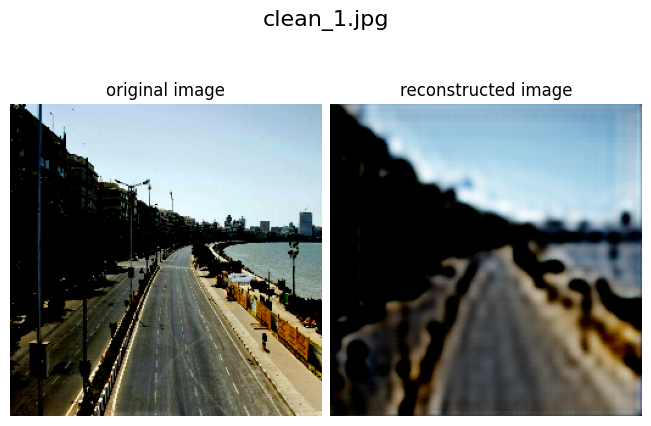

In [56]:
import matplotlib.pyplot as plt

original_img = create_img_to_show(input_img)
reconstructed_img = create_img_to_show(output)

fig, axs = plt.subplots(1, 2, constrained_layout=True)
axs[0].imshow(original_img)
axs[0].set_title('original image')
axs[0].axis('off')

fig.suptitle(args.img_name, fontsize=16)

axs[1].imshow(reconstructed_img)
axs[1].set_title('reconstructed image')
axs[1].axis('off')

plt.show()

# Show memory item
In order to show a memory item it's necessary to forward it in the encoder. The encoder takes as input a tensor with 1024 channel because it is the concatenation of the query (input coming from encoder) and the weighted memory item.

First of all it is necessary to format the memory item as an input coming from encoder.

Then I tried two strategies:
- Provide as input a memory item concatenated with itself.
- Provide as input a memory item to the read function defined in the memory module that will create the input for the decoder.

## Pick one memory item

In [57]:
m_item = m_items[0]
# Save unmodified memory item to use it as key
m_item_original = m_item.clone()

## Preprocess memory item for decoder forwarding

### Format as output from encoder

In [58]:
from torch.nn import functional as F
# Input of memory module coming from encoder it's formatted as (batch_size, channels, height, width)
encoder_out_test = model.encoder(img_to_forward)
print("Encoder output shape:\n{}".format(encoder_out_test.shape))
# Actual memory item shape is only (channels)
print("Memory item shape:\n{}".format(m_item.shape))
# Add batch dimension
m_item = m_item.unsqueeze(0)
# Add height and width dimensions
m_item = m_item.unsqueeze(2)
m_item = m_item.unsqueeze(3)
print("Memory item shape after adding batch, height and width dimensions:\n{}".format(m_item.shape))

Encoder output shape:
torch.Size([1, 512, 32, 32])
Memory item shape:
torch.Size([512])
Memory item shape after adding batch, height and width dimensions:
torch.Size([1, 512, 1, 1])


### Format as input for decoder

#### Just concatenate

In [59]:
m_item_concatenated = torch.cat((m_item, m_item), 1)
print("Memory item concatenated shape:\n{}".format(m_item_concatenated.shape))

Memory item concatenated shape:
torch.Size([1, 1024, 1, 1])


#### Use read function from Memory module

##### Prepare for read function

In [60]:
# Before the application of read function, the query is normalized and formatted as (batch_size, height, width, channels)
m_item_read_function = F.normalize(m_item, dim=1)
m_item_read_function = m_item_read_function.permute(0,2,3,1) # b X h X w X d
print("Memory item prepared for read function shape:\n{}".format(m_item_read_function.shape))

Memory item prepared for read function shape:
torch.Size([1, 1, 1, 512])


##### Function definition from Memory.py

In [61]:
from torch.nn import functional as F

def get_score(mem, query):
    bs, h,w,d = query.size()
    m, d = mem.size()
        
    score = torch.matmul(query, torch.t(mem))# b X h X w X m
    score = score.view(bs*h*w, m)# (b X h X w) X m
        
    score_query = F.softmax(score, dim=0)
    score_memory = F.softmax(score,dim=1)
        
    return score_query, score_memory

def read(query, updated_memory):
    batch_size, h,w,dims = query.size() # b X h X w X d

    softmax_score_query, softmax_score_memory = get_score(updated_memory, query)

    query_reshape = query.contiguous().view(batch_size*h*w, dims)
        
    concat_memory = torch.matmul(softmax_score_memory.detach(), updated_memory) # (b X h X w) X d
    updated_query = torch.cat((query_reshape, concat_memory), dim = 1) # (b X h X w) X 2d
    updated_query = updated_query.view(batch_size, h, w, 2*dims)
    updated_query = updated_query.permute(0,3,1,2)
        
    return updated_query, softmax_score_query, softmax_score_memory

##### Application

In [62]:
# Using only the selected memory item
m_item_read_decoder, _, _ = read(m_item_read_function, m_item_original.unsqueeze(0))
# Using all memory items
#m_item_read_decoder, _, _ = read(m_item_read_function, m_items)
print("Memory item after read function shape:\n{}".format(m_item_read_decoder.shape))

Memory item after read function shape:
torch.Size([1, 1024, 1, 1])


## Forward adjusted memory item in decoder

In [63]:
m_item_out_concat = model.decoder(m_item_concatenated)
m_item_out_read = model.decoder(m_item_read_decoder)
print("Decoder output shape:\n{}".format(m_item_out_concat.shape))

Decoder output shape:
torch.Size([1, 3, 8, 8])


### Forward post processing

In [64]:
# Remove batch dimension
m_item_out_concat = m_item_out_concat.squeeze(0)
m_item_out_read = m_item_out_read.squeeze(0)
# Insert image in CPU
if args.gpus is not None and torch.cuda.is_available():
    m_item_out_concat = m_item_out_concat.cpu()
    m_item_out_read = m_item_out_read.cpu()
# Detach the output (remove it from the computational graph)
m_item_out_concat = m_item_out_concat.detach()
m_item_out_read = m_item_out_read.detach()
# Show the output
#m_item_out_concat
#m_item_out_read

## Draw memory item

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4335265..0.13667776].


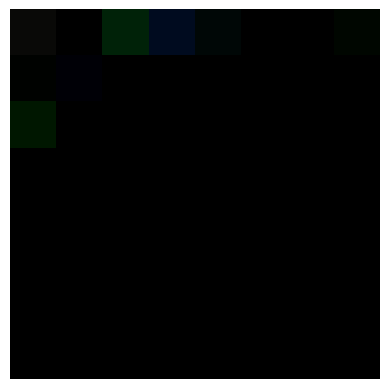

In [65]:
memory_img = create_img_to_show(m_item_out_concat)
#memory_img = create_img_to_show(m_item_out_read)

plt.imshow(memory_img)
plt.axis('off')
plt.show()

## Show difference between two strategies

In [66]:
res = torch.isclose(m_item_out_read, m_item_out_concat, atol=1e-06)
# All the elements
print("Number of elements in memory item: {}".format(res.numel()))
# Number of elements that are not close
print("Number of elements that are not close: {}".format(torch.count_nonzero(~res)))

#res

Number of elements in memory item: 192
Number of elements that are not close: 0
